Objective : In this capstone project, you will create a presentation that showcases a portfolio of stocks that you recommend your client invest in, and provide the weights at which they should invest in each stock depending on their risk preference.

The purpose of this capstone is to practice accessing and downloading financial data, calculating financial statistics to understand the individual performance of an asset and how groups of assets are related, and how to allocate investments across assets for optimal performance

Stocks Picked: GOOG, QCOM, LMT, FB, AMD, VISA

<b>Code Starts</b>

Importing relevant libraries

In [1]:
import numpy as np
import random
import pandas as pd
import pandas_datareader as web
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
import yfinance as yf
import cvxopt as opt
from cvxopt import blas, solvers

Defining Stocks to be analyzed

In [2]:
stocks = ['GOOG','QCOM','LMT','FB','AMD','V']

Importing 5 years' daily close prices (adjusted) with Yahoo Finance API of all the stocks

In [3]:
start_date = dt.datetime(2017,3,1)
end_date = dt.datetime(2022,2,28)
prices = web.get_data_yahoo(stocks,start_date,end_date)
adj_close_prices = prices['Adj Close']

Return Calculation

In [4]:
selected=list(adj_close_prices.columns[1:])
simple_ror = adj_close_prices[selected].pct_change()

Calculating mean and standard deviation of simple return

In [5]:
mean_return = simple_ror.mean()
return_std = simple_ror.std()

Ploting Mean and Standard Deviations

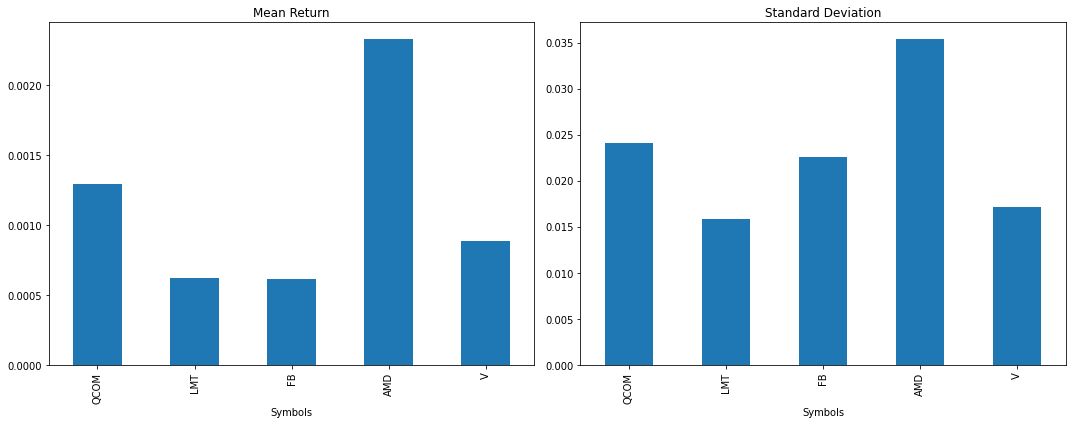

In [21]:
plt.figure(figsize=(15,6))
ax =plt.subplot(121)
mean_return.plot.bar()
ax.set_title('Mean Return')
plt.savefig('Mean Return.png')
ax1 = plt.subplot(122)
return_std.plot.bar()
ax1.set_title('Standard Deviation')
plt.savefig('Standard Deviation.png')
plt.tight_layout()
plt.show()

Calculating correlations among the stocks

In [23]:
correlation = simple_ror.corr()
correlation.to_csv('correlation.csv')

Calculating Covariacne for portfolio optimiation calculation

In [8]:
covr = simple_ror.cov()
print(covr)

Symbols      QCOM       LMT        FB       AMD         V
Symbols                                                  
QCOM     0.000578  0.000108  0.000226  0.000391  0.000193
LMT      0.000108  0.000250  0.000097  0.000128  0.000137
FB       0.000226  0.000097  0.000508  0.000311  0.000200
AMD      0.000391  0.000128  0.000311  0.001254  0.000245
V        0.000193  0.000137  0.000200  0.000245  0.000293


Defining portfolio optimization module

In [9]:
def return_portfolios(expected_returns, cov_matrix):
  np.random.seed(1)
  port_returns = []
  port_volatility = []
  stock_weights = []
    
  selected = (expected_returns.axes)[0]
    
  num_assets = len(selected) 
  num_portfolios = 5000
    
  for single_portfolio in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    returns = np.dot(weights, expected_returns)
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    port_returns.append(returns)
    port_volatility.append(volatility)
    stock_weights.append(weights)
    
    portfolio = {'Returns': port_returns,
                 'Volatility': port_volatility}
    
  for counter,symbol in enumerate(selected):
    portfolio[symbol +' Weight'] = [Weight[counter] for Weight in stock_weights]
    
  df = pd.DataFrame(portfolio)
    
  column_order = ['Returns', 'Volatility'] + [stock+' Weight' for stock in selected]
    
  df = df[column_order]
   
  return df

Plotting Mean-Variance tradeoff for 5,000 random portfolios

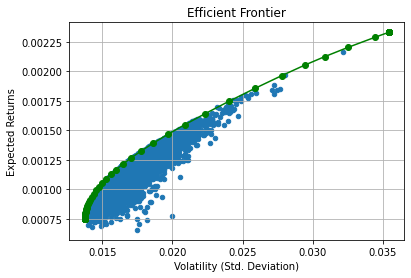

In [30]:
random_portfolios = return_portfolios(mean_return,covr)
random_portfolios.plot.scatter(x = 'Volatility', y ='Returns')
#plt.xlabel('Volatility (Std. Deviation)')
#plt.ylabel('Expected Returns')
#plt.title('Mean-Variance Tradeoff')
plt.plot(risks, returns, 'g-o')
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.grid()
#plt.show()
#plt.show()
plt.savefig('Efficient Frontier.png')

Defining optimal portfolio module

In [11]:
def optimal_portfolio(returns):
    n = returns.shape[1]
    returns = np.transpose(returns.to_numpy())

    N = 100
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]

    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(np.mean(returns, axis=1))

    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)

    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x']
                  for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return np.asarray(wt), returns, risks


Finding the optimal portfolio

In [12]:
weights, returns, risks = optimal_portfolio(simple_ror[1:])

     pcost       dcost       gap    pres   dres
 0: -1.1370e-03 -1.0023e+00  1e+00  2e-16  3e+00
 1: -1.1378e-03 -1.2299e-02  1e-02  9e-17  3e-02
 2: -1.2078e-03 -2.3955e-03  1e-03  8e-17  3e-03
 3: -2.1867e-03 -2.8187e-03  6e-04  4e-16  8e-04
 4: -2.2614e-03 -2.2742e-03  1e-05  2e-16  2e-05
 5: -2.2686e-03 -2.2687e-03  1e-07  2e-16  2e-07
 6: -2.2687e-03 -2.2687e-03  1e-09  7e-21  2e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.1353e-03 -1.0023e+00  1e+00  2e-16  3e+00
 1: -1.1361e-03 -1.2295e-02  1e-02  1e-16  3e-02
 2: -1.2058e-03 -2.3911e-03  1e-03  2e-16  3e-03
 3: -2.1817e-03 -2.8103e-03  6e-04  4e-16  8e-04
 4: -2.2540e-03 -2.2665e-03  1e-05  1e-16  2e-05
 5: -2.2610e-03 -2.2611e-03  1e-07  2e-16  2e-07
 6: -2.2610e-03 -2.2610e-03  1e-09  3e-16  2e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.1334e-03 -1.0023e+00  1e+00  0e+00  3e+00
 1: -1.1342e-03 -1.2290e-02  1e-02  7e-17  3e-02
 2: -1.2035e-03 -2.3862e

 1: -8.7281e-04 -1.1678e-02  1e-02  2e-16  3e-02
 2: -9.0710e-04 -1.7346e-03  8e-04  8e-17  2e-03
 3: -1.1493e-03 -1.4244e-03  3e-04  1e-16  3e-19
 4: -1.1787e-03 -1.2193e-03  4e-05  2e-16  3e-19
 5: -1.1920e-03 -1.1954e-03  3e-06  1e-16  5e-19
 6: -1.1935e-03 -1.1937e-03  2e-07  2e-16  1e-19
 7: -1.1936e-03 -1.1936e-03  2e-09  2e-16  3e-19
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -8.3845e-04 -1.0016e+00  1e+00  2e-16  3e+00
 1: -8.3882e-04 -1.1598e-02  1e-02  6e-17  3e-02
 2: -8.6972e-04 -1.6525e-03  8e-04  5e-17  2e-03
 3: -1.0691e-03 -1.2985e-03  2e-04  1e-16  3e-19
 4: -1.0958e-03 -1.1273e-03  3e-05  3e-17  4e-19
 5: -1.1051e-03 -1.1070e-03  2e-06  3e-17  1e-19
 6: -1.1061e-03 -1.1063e-03  2e-07  7e-17  4e-19
 7: -1.1062e-03 -1.1063e-03  6e-09  2e-16  3e-19
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -8.0036e-04 -1.0015e+00  1e+00  0e+00  3e+00
 1: -8.0068e-04 -1.1509e-02  1e-02  1e-16  3e-02
 2: -8.2811e-04 -1.5612

     pcost       dcost       gap    pres   dres
 0:  7.4464e-03 -1.0001e+00  1e+00  2e-16  3e+00
 1:  7.3803e-03 -9.9564e-03  2e-02  8e-17  5e-02
 2:  5.9138e-03  2.7248e-03  3e-03  7e-17  6e-03
 3:  5.2730e-03  4.8665e-03  4e-04  1e-16  5e-18
 4:  5.2068e-03  5.1778e-03  3e-05  9e-17  6e-18
 5:  5.1981e-03  5.1945e-03  4e-06  2e-16  4e-18
 6:  5.1972e-03  5.1967e-03  4e-07  6e-17  3e-18
 7:  5.1971e-03  5.1971e-03  2e-08  1e-16  5e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  8.4676e-03 -9.9995e-01  1e+00  2e-16  3e+00
 1:  8.3842e-03 -9.8265e-03  2e-02  6e-17  5e-02
 2:  6.6726e-03  3.3479e-03  3e-03  7e-17  6e-03
 3:  6.0076e-03  5.6073e-03  4e-04  2e-16  3e-18
 4:  5.9364e-03  5.9063e-03  3e-05  1e-16  3e-18
 5:  5.9263e-03  5.9224e-03  4e-06  1e-16  3e-18
 6:  5.9250e-03  5.9245e-03  5e-07  1e-16  3e-18
 7:  5.9249e-03  5.9248e-03  6e-08  1e-16  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  9.6068e-03 -9.9982e

 2:  1.8871e-01  1.8183e-01  7e-03  6e-17  5e-17
 3:  1.8770e-01  1.8739e-01  3e-04  4e-17  7e-17
 4:  1.8752e-01  1.8750e-01  1e-05  1e-16  1e-16
 5:  1.8751e-01  1.8751e-01  1e-07  2e-16  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.2987e-01 -8.6651e-01  1e+00  0e+00  3e+00
 1:  2.2178e-01  1.4620e-01  8e-02  1e-16  2e-01
 2:  2.1160e-01  2.0525e-01  6e-03  1e-16  7e-17
 3:  2.1065e-01  2.1038e-01  3e-04  4e-17  9e-17
 4:  2.1049e-01  2.1047e-01  1e-05  1e-16  1e-16
 5:  2.1048e-01  2.1048e-01  1e-07  1e-16  6e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.5551e-01 -8.4466e-01  1e+00  0e+00  3e+00
 1:  2.4696e-01  1.7090e-01  8e-02  2e-16  2e-01
 2:  2.3729e-01  2.3149e-01  6e-03  2e-16  1e-16
 3:  2.3641e-01  2.3617e-01  2e-04  1e-16  9e-17
 4:  2.3626e-01  2.3625e-01  7e-06  1e-16  1e-16
 5:  2.3625e-01  2.3625e-01  7e-08  1e-16  8e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres


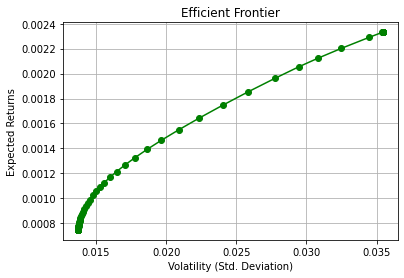

In [13]:
plt.plot(risks, returns, 'g-o')
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.grid()
plt.show()

Defining a portfolio recommendation module that selects the most suitable option of all the 5,000 randomly generated portfolio
given a particular risk tolerance level.

In [16]:
def portfolio_recommendation(random_portfolios,maximum_volatility_tolerance):
    eligible_portfolios = random_portfolios[(random_portfolios.Volatility<=maximum_volatility_tolerance)]
    max_return = eligible_portfolios.Returns.max()
    max_return_portfolio = eligible_portfolios[eligible_portfolios.Returns == max_return]
    return max_return_portfolio

Making portfolio recommendation for 3 different risk tolerance level.

In [34]:
low_risk = 0.02
medium_risk = 0.03
high_risk = 0.04

low_risk_portfolio = portfolio_recommendation(random_portfolios,low_risk)
medium_risk_portfolio = portfolio_recommendation(random_portfolios,medium_risk)
high_risk_portfolio = portfolio_recommendation(random_portfolios,high_risk)
all_recommendations = pd.concat([low_risk_portfolio,medium_risk_portfolio,high_risk_portfolio],    
                          ignore_index = True,
                          sort = False)
print(all_recommendations)
all_recommendations.to_csv('Recommendations.csv')

    Returns  Volatility  QCOM Weight  LMT Weight  FB Weight  AMD Weight  \
0  0.001480    0.019989     0.291486    0.079910   0.003442    0.344081   
1  0.001969    0.028044     0.164610    0.002887   0.005774    0.703992   
2  0.002160    0.032119     0.022336    0.048601   0.006006    0.885151   

   V Weight  
0  0.281081  
1  0.122738  
2  0.037905  
